In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, max_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
df_option = pd.read_pickle("NFLX_trainning_master_data.pkl")

In [3]:
df_option.columns

Index(['Target_std', 'Target_spread', 'prior_std', 'prior_Vol', 'prior_spread',
       'prior_range', 'cut_close', 'cut_1hr', 'cut_2hr', 'cut_3hr',
       'vix_prior_std', 'vix_pr_spread', 'vix_prior_range', 'vix_cut_open',
       'vix_cut_1hr', 'vix_cut_2hr', 'vix_cut_3hr', 'tqqq_prior_std',
       'tqqq_Vol', 'tqqq_pr_spread', 'tqqq_prior_range', 'tqqq_cut_open',
       'tqqq_cut_1hr', 'tqqq_cut_2hr', 'tqqq_cut_3hr'],
      dtype='object')

In [4]:
len(df_option.columns)

25

<Axes: >

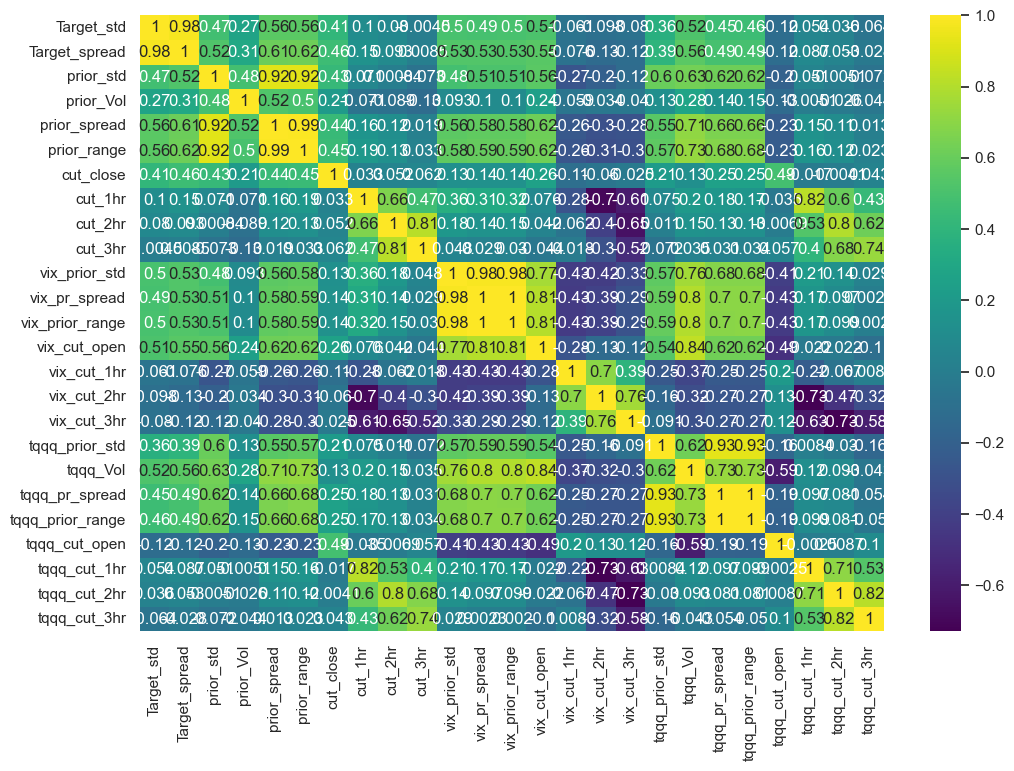

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(df_option.corr(numeric_only=True),cmap='viridis',annot=True)

<Axes: ylabel='Frequency'>

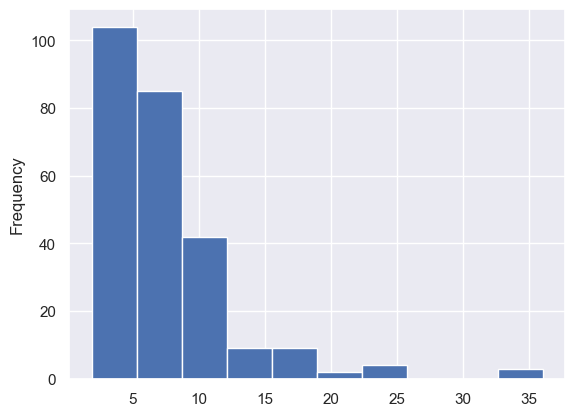

In [5]:
df_option.Target_spread.plot.hist()

In [7]:
#sns.catplot(x='OP_EXP',y='Target_std',data=df_option, kind='box')

In [6]:
df_option.reset_index(inplace=True)

## Splitting the Data


In [31]:
X = df_option.drop(['Date_Only','Target_std','Target_spread','cut_3hr','vix_cut_3hr','tqqq_cut_3hr'], axis=1)  
#y = df_option['Target_std']
y = df_option['Target_spread']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [33]:
X_train.columns

Index(['prior_std', 'prior_Vol', 'prior_spread', 'prior_range', 'cut_close',
       'cut_1hr', 'cut_2hr', 'vix_prior_std', 'vix_pr_spread',
       'vix_prior_range', 'vix_cut_open', 'vix_cut_1hr', 'vix_cut_2hr',
       'tqqq_prior_std', 'tqqq_Vol', 'tqqq_pr_spread', 'tqqq_prior_range',
       'tqqq_cut_open', 'tqqq_cut_1hr', 'tqqq_cut_2hr'],
      dtype='object')

In [34]:
X_train.shape

(206, 20)

In [35]:
y_train.shape

(206,)

## Evaluation Run Model with the Data


In [36]:
def run_model(model,X_train,y_train,X_test,y_test):
    
    # Fit Model
    model.fit(X_train,y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test,preds)
    print(f'mae : {mae}')
   
    
    plt.figure(figsize=(12,8),dpi=200)
    plt.scatter(y_test, preds)
    plt.plot(y_test, y_test, color='green', linestyle='dashed')
    plt.xlabel('real_std')

    return model

----

## Support Vector Regression

In [37]:
from sklearn.svm import SVR

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
scaler = StandardScaler()
sc_X_train = scaler.fit_transform(X_train)
sc_X_test = scaler.transform(X_test)

In [40]:
param_grid = {'C':[0.01,0.1,1,5,10,100,1000],'gamma':['auto','scale']}
svr = SVR()

In [41]:
grid = GridSearchCV(svr,param_grid)

mae : 2.250057844372496


GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 5, 10, 100, 1000],
                         'gamma': ['auto', 'scale']})

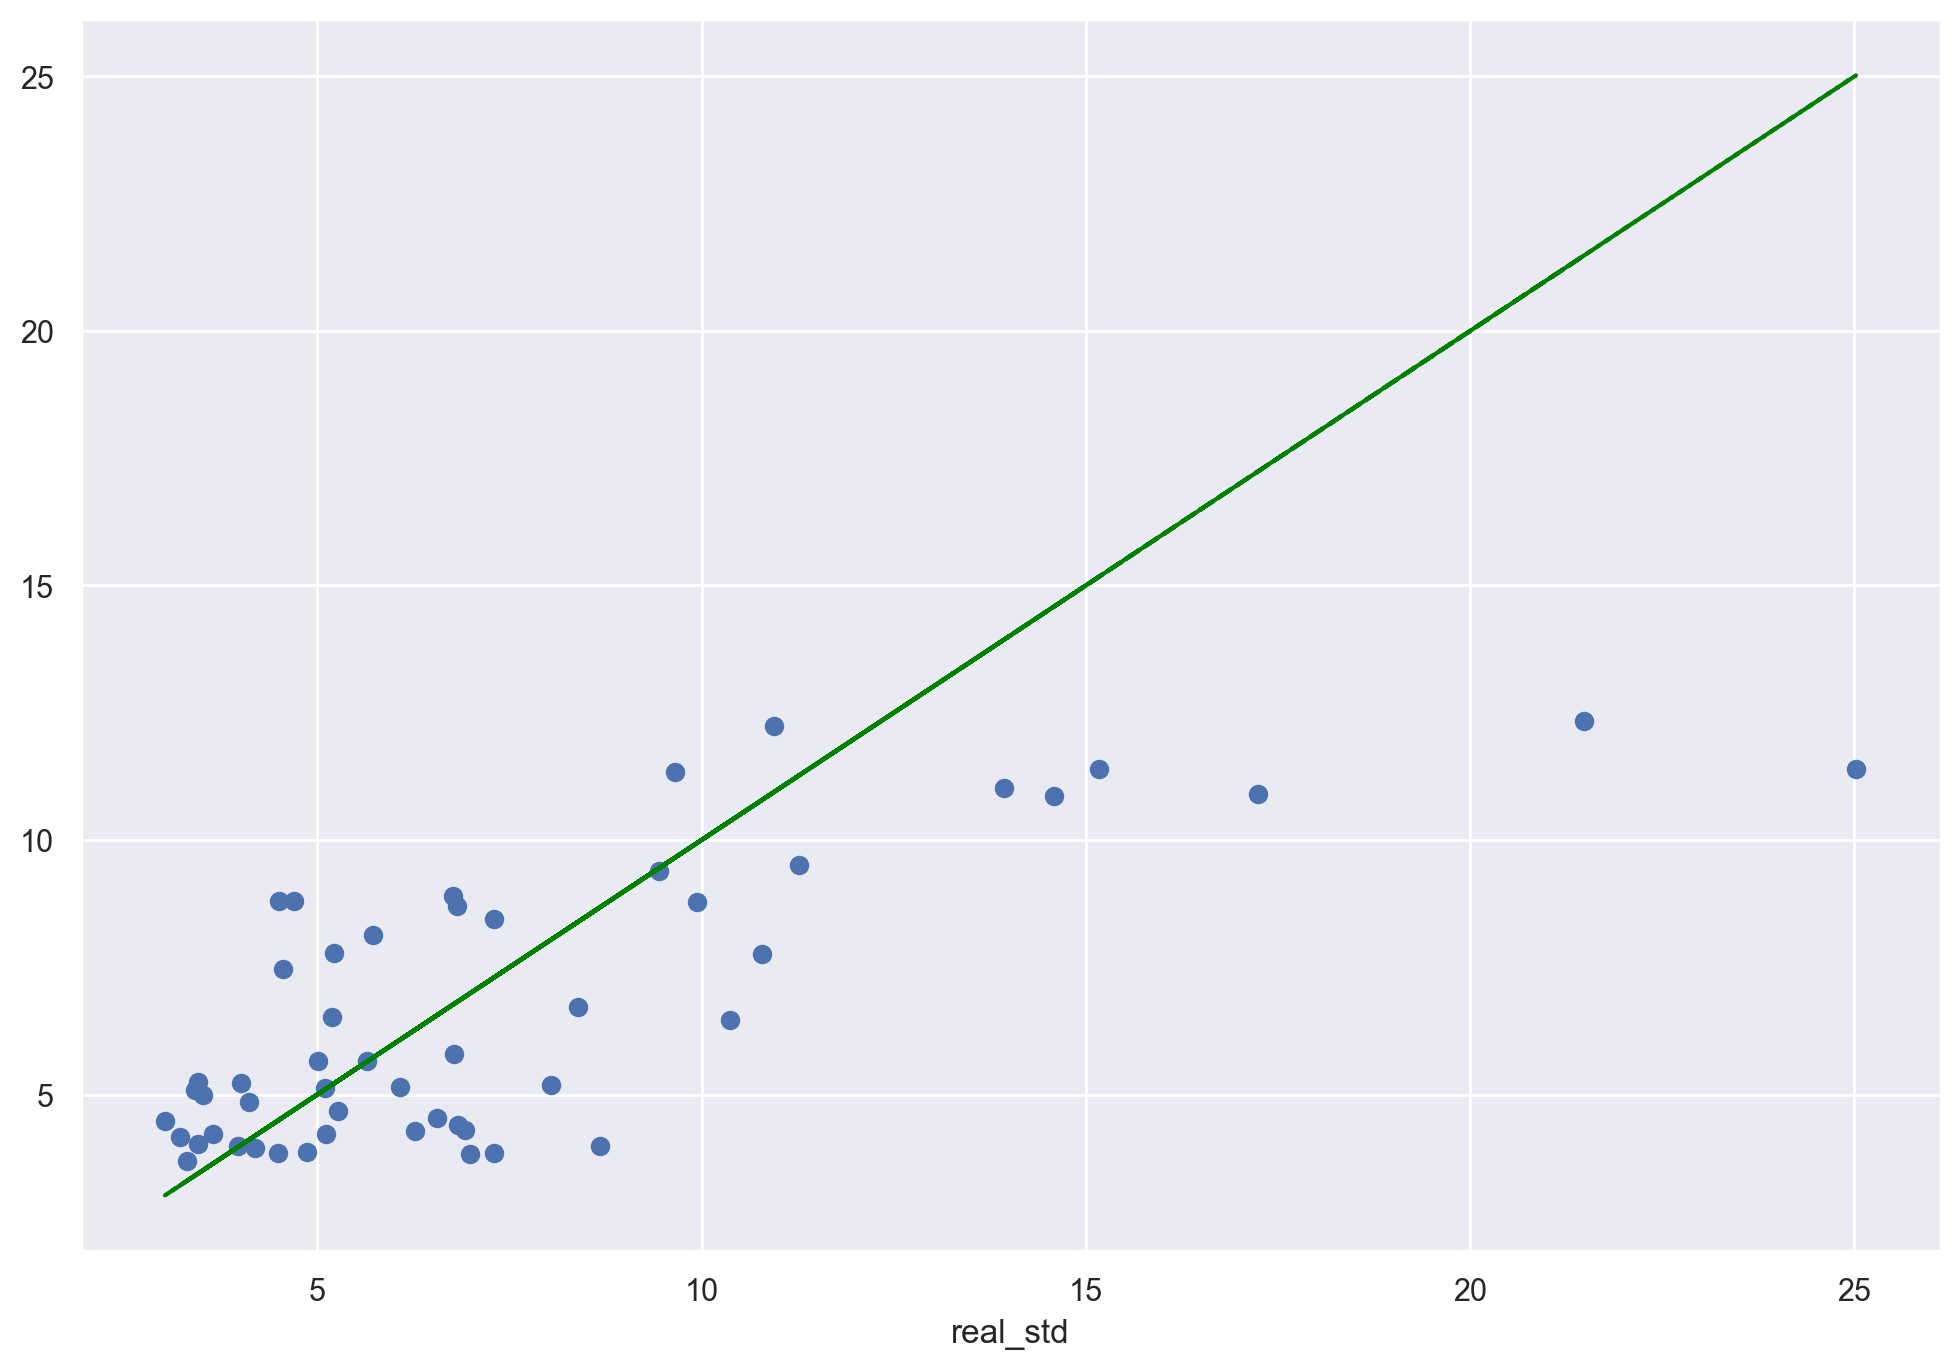

In [42]:
run_model(grid,sc_X_train,y_train,sc_X_test,y_test)

In [43]:
scaler_filename = "scaler4svr_NFLX.save"
joblib.dump(scaler, scaler_filename)

['scaler4svr_NFLX.save']

In [44]:
SVR_model = grid.best_estimator_

In [45]:
filename = 'SVR_model_NFLX.joblib'
joblib.dump(SVR_model, filename)

['SVR_model_NFLX.joblib']

---

## Random Forest Regression

## Gradient Boosting


In [46]:
from sklearn.ensemble import GradientBoostingRegressor

In [47]:
# help(GradientBoostingRegressor)

mae : 2.2279937085333477


GradientBoostingRegressor()

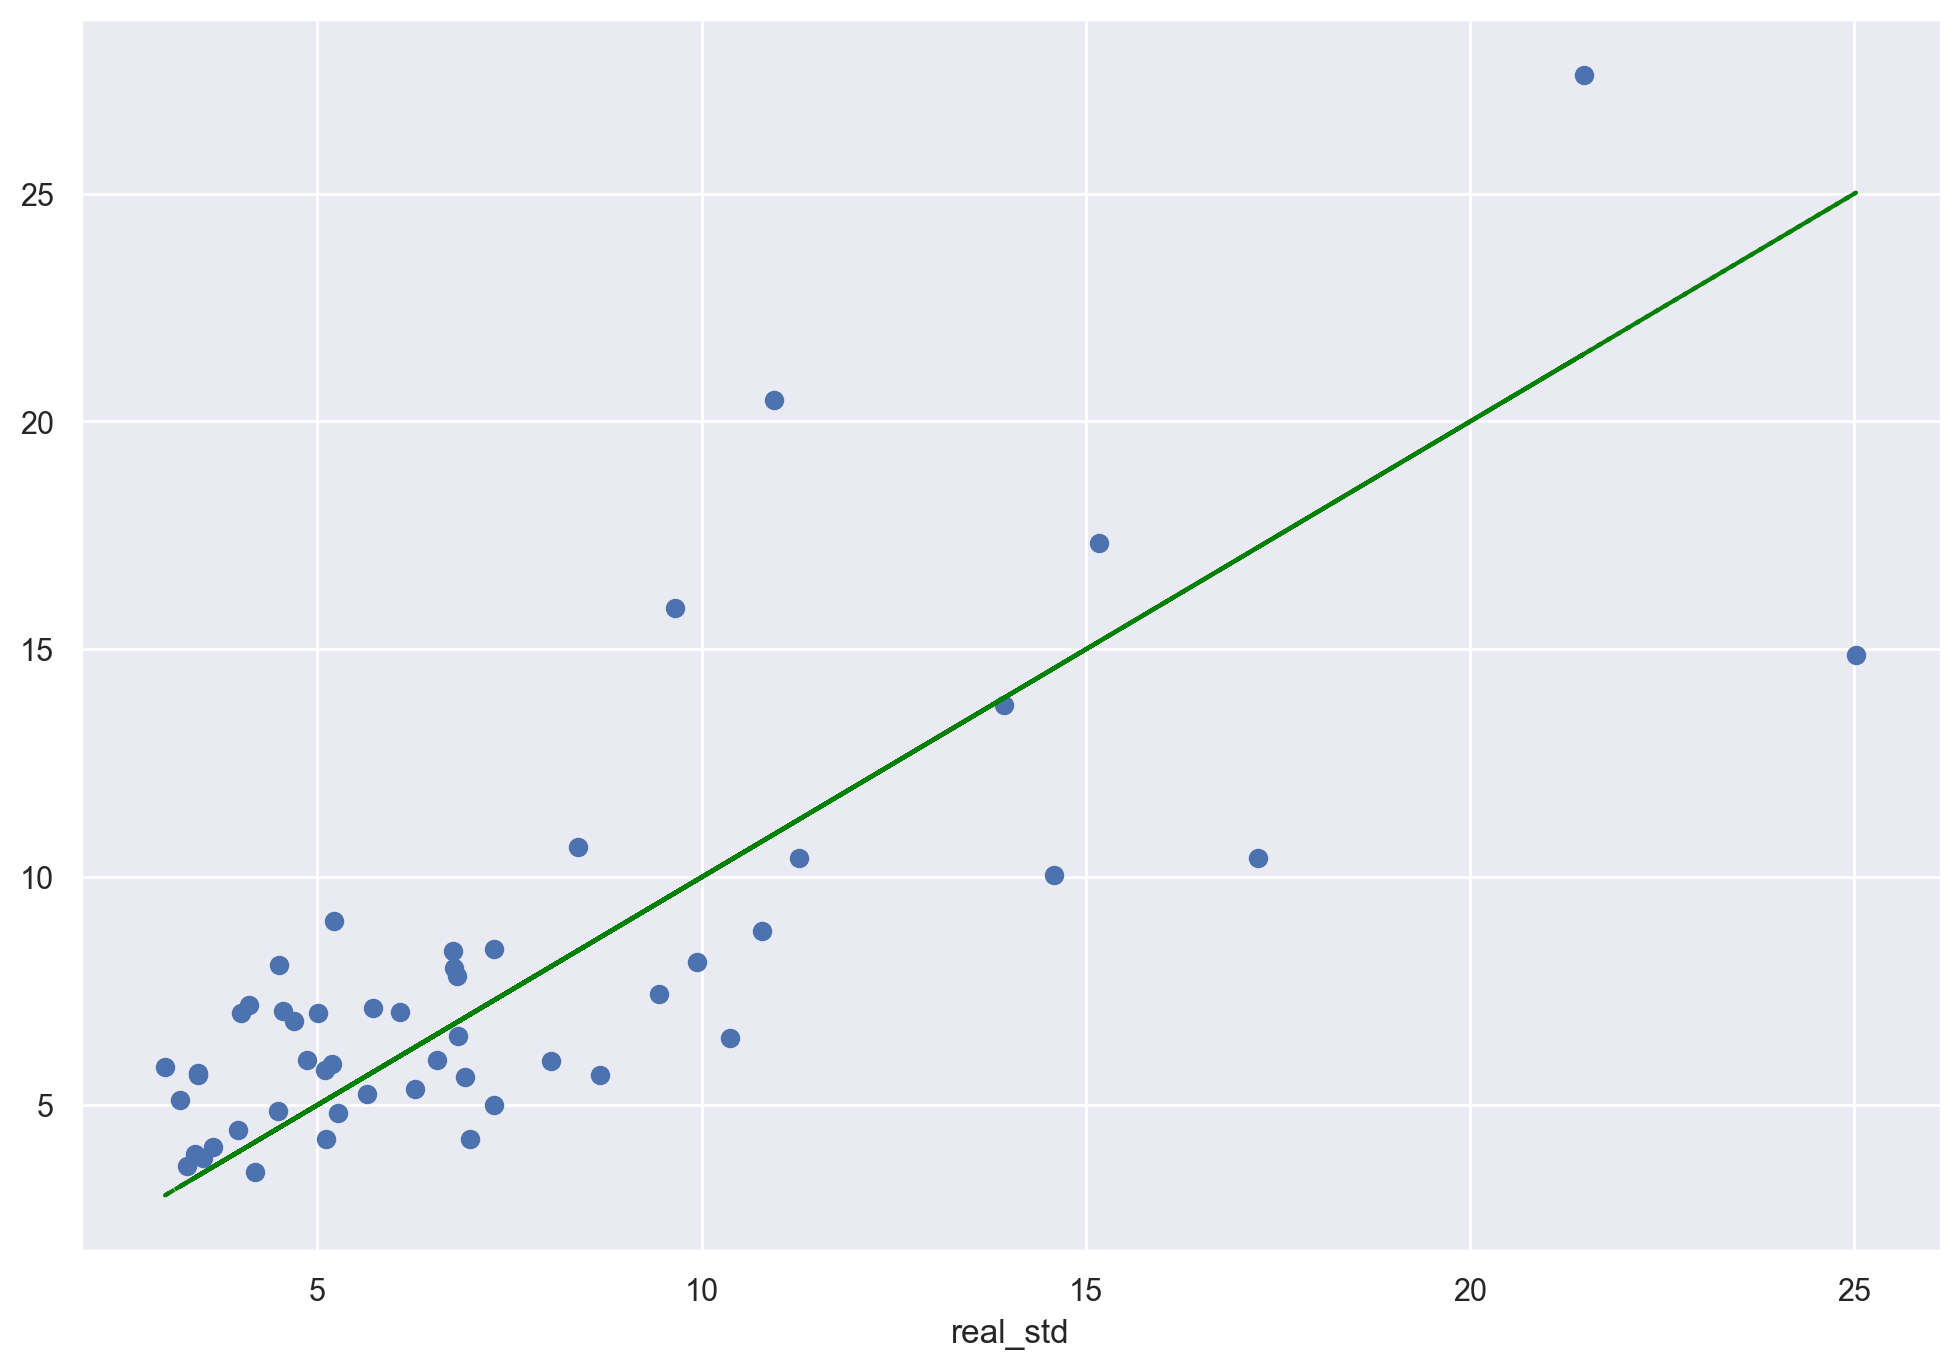

In [48]:
   
model = GradientBoostingRegressor()

run_model(model,X_train,y_train,X_test,y_test)

In [49]:
import xgboost as xgb
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Initialize XGBoost regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgbr,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=10,
                           verbose=0,
                          n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", np.sqrt(-grid_search.best_score_))

# Evaluate the best model on the test set
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Best score: 4.152787082688294
Test RMSE: 2.7796332231709893


mae : 2.1440693946985094


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

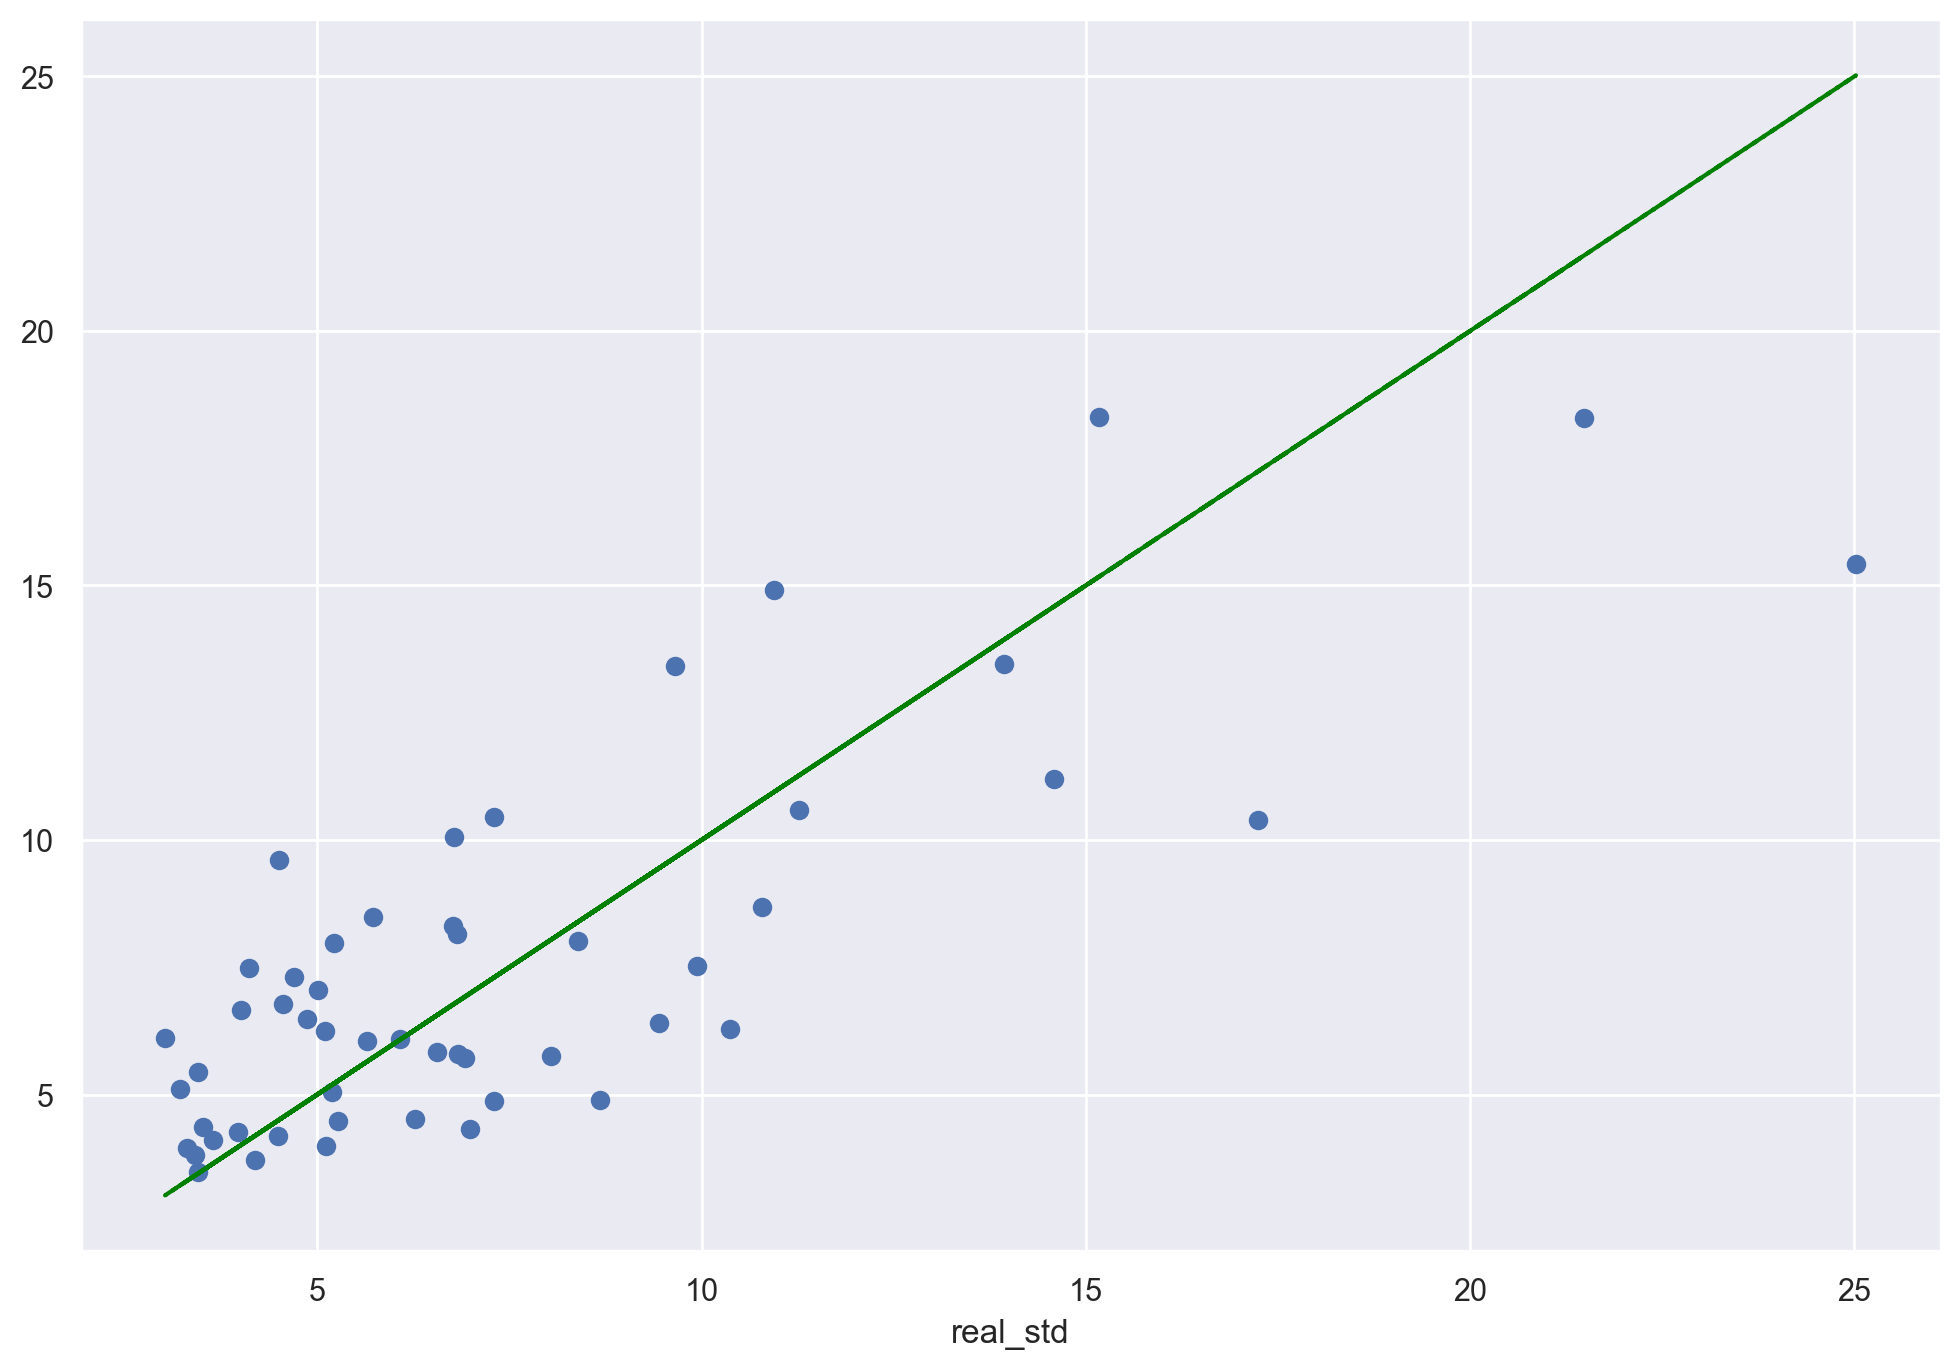

In [50]:
run_model(best_xgb_model,X_train,y_train,X_test,y_test)

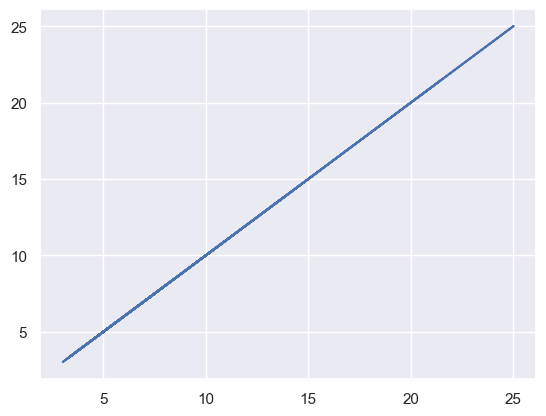

In [51]:
plt.plot(y_test, y_test)

In [52]:
pd.DataFrame(index=X.columns,data=best_xgb_model.feature_importances_,columns=['Feature Importance'])

,Feature Importance
prior_std,0.032065
prior_Vol,0.030856
prior_spread,0.071527
prior_range,0.050997
cut_close,0.104291
cut_1hr,0.025035
cut_2hr,0.031710
vix_prior_std,0.033275
vix_pr_spread,0.037370
vix_prior_range,0.036216


In [53]:
X_train

,prior_std,prior_Vol,prior_spread,prior_range,cut_close,cut_1hr,cut_2hr,vix_prior_std,vix_pr_spread,vix_prior_range,vix_cut_open,vix_cut_1hr,vix_cut_2hr,tqqq_prior_std,tqqq_Vol,tqqq_pr_spread,tqqq_prior_range,tqqq_cut_open,tqqq_cut_1hr,tqqq_cut_2hr
160,9.498253,6271.179167,34.90,35.00,841.41,-2.32,-1.70,0.080801,0.33,0.33,15.67,0.12,-0.04,0.608045,95685.008333,2.34,2.33,75.91,-0.09,-0.52
196,3.701383,4310.887500,16.19,16.05,852.21,-5.56,-5.63,0.149191,0.71,0.73,16.11,0.02,0.27,0.293962,107366.150000,1.95,1.62,80.34,-0.75,-0.60
159,3.058152,4593.433333,14.41,14.53,820.25,3.35,-0.07,0.645585,2.03,2.02,17.32,0.35,0.63,0.934182,147069.270833,3.45,3.44,74.06,-0.15,-1.13
132,1.195687,2263.487500,6.45,6.38,724.96,0.80,3.15,0.064801,0.32,0.30,20.81,-0.13,-0.06,0.602403,96782.808333,2.19,2.18,73.97,0.07,0.34
80,2.309140,4274.558333,12.40,12.54,638.24,1.21,4.32,0.259041,0.95,0.95,16.80,0.35,0.23,0.755215,160295.650000,2.43,2.44,66.27,0.65,1.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,5.323134,3841.004167,22.37,21.45,707.18,2.16,3.01,0.106793,0.49,0.50,15.38,-0.27,-0.23,0.780689,138581.095833,3.24,3.01,72.24,-0.25,-0.23
113,2.694578,2925.216667,11.72,12.01,687.00,3.29,2.28,0.266674,0.93,0.96,17.08,-0.32,-0.53,0.482943,135895.225000,2.28,2.29,66.11,0.98,1.25
64,2.615400,2134.500000,11.24,11.14,676.24,0.89,-2.87,0.129005,0.46,0.45,11.86,-0.10,-0.24,0.463892,92640.212500,2.26,2.20,76.46,0.86,0.64
15,3.390768,12583.508333,13.83,13.96,551.96,-0.14,-1.90,0.474136,1.48,1.49,16.75,-0.21,-0.76,0.392080,161555.204167,1.58,1.67,50.87,0.61,1.06


In [54]:
import joblib
# Assuming 'model' is your trained model object
filename = 'xgb_model_NFLX_price_spread_update.joblib'
joblib.dump(best_xgb_model, filename)


['xgb_model_NFLX_price_spread_update.joblib']

In [ ]:
pwd

----